In [150]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [151]:
#Download the required libraries
from __future__ import print_function, division

import numpy as np
import torch
import torchvision
import os
import copy
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.onnx
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import cv2
from collections import Counter

%matplotlib inline

plt.ion()   # interactive moden

In [152]:
#get address
data_dir="/content/drive/MyDrive/datasets/"

#Create function to get your(my) images dataset and resize it to size for model
def get_dataset(data_dir, data_transforms):

    # create train and test datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'test']}

    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                 shuffle=True, num_workers=4)
                  for x in ['train', 'test']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    #get classes from train dataset folders name
    classes = image_datasets['train'].classes

    return dataloaders["train"], dataloaders['test'], classes, dataset_sizes

In [153]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)


In [154]:
riterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cpu")

**Transer Learning**

pretrained model Renset18 train datasets

In [155]:
#Data scaled and normalization for training and testing for resnet18
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [156]:
trainloader, testloader, classes, dataset_sizes=get_dataset(data_dir, data_transforms)
print('Classes: ',  classes)
print('The datasest have: ',  dataset_sizes ," images")

Classes:  ['arial', 'calibri', 'times new roman', 'verdana']
The datasest have:  {'train': 414, 'test': 134}  images


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [157]:
# Create new image show function for new transofration 
def imshow_resNet18(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


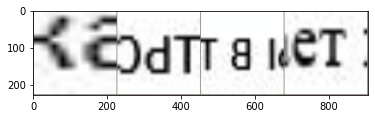

calibri calibri calibri times new roman


In [158]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
#images, labels = dataiter.next()

# show images
imshow_resNet18(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Функция обучения модели

In [159]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Параметры для обучения модели

In [160]:
# Let's prepare the parameters for training the model
dataloaders = {'train': trainloader, 'test': testloader}
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Обучение модели

In [161]:
#Train the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.1571 Acc: 0.4831
test Loss: 1.0254 Acc: 0.6343

Epoch 1/24
----------
train Loss: 1.1256 Acc: 0.5628
test Loss: 0.8164 Acc: 0.7164

Epoch 2/24
----------
train Loss: 0.7610 Acc: 0.7222
test Loss: 1.1079 Acc: 0.6866

Epoch 3/24
----------
train Loss: 0.7468 Acc: 0.7391
test Loss: 0.8174 Acc: 0.7239

Epoch 4/24
----------
train Loss: 0.5388 Acc: 0.8068
test Loss: 0.7427 Acc: 0.7612

Epoch 5/24
----------
train Loss: 0.6750 Acc: 0.7585
test Loss: 0.9892 Acc: 0.7761

Epoch 6/24
----------
train Loss: 0.6620 Acc: 0.7633
test Loss: 0.6114 Acc: 0.8134

Epoch 7/24
----------
train Loss: 0.4880 Acc: 0.8164
test Loss: 0.6438 Acc: 0.7985

Epoch 8/24
----------
train Loss: 0.3070 Acc: 0.8889
test Loss: 0.5712 Acc: 0.8507

Epoch 9/24
----------
train Loss: 0.3100 Acc: 0.8913
test Loss: 0.4819 Acc: 0.8731

Epoch 10/24
----------
train Loss: 0.3712 Acc: 0.8454
test Loss: 0.5298 Acc: 0.8806

Epoch 11/24
----------
train Loss: 0.3315 Acc: 0.8768
test Loss: 0.5241 Acc: 0.8806

Epoch 12/24


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.1399,  2.8096, -3.1854,  0.5473])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-1.6298, -1.0012, -1.1856,  5.6522])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-1.3310,  0.2602, -2.7486,  6.0409])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 2.1346, -0.7460, -3.7868,  4.7586])


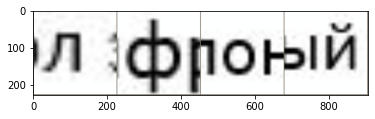

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.0085,  5.4290,  3.1430, -7.0415])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-1.5943, -0.8596,  6.4425, -3.5121])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.0134,  4.2880, -0.0846, -2.8930])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-3.2319, -2.7277,  8.5901, -2.5057])


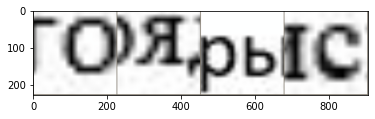

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 0.7625, -0.5146, -2.2825,  3.0700])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 0.7549,  0.7095, -2.0845,  1.3450])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-0.4651, -3.7049,  8.7245, -4.2109])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 1.3904,  2.0560,  4.9970, -6.6510])


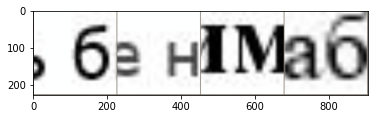

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-1.0875,  5.2188, -0.0063, -1.8740])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-1.7875, -3.6826, 11.1881, -5.5341])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 3.1754,  4.1781, -4.0047, -0.9496])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 0.6549,  1.1085, -4.0815,  5.4271])


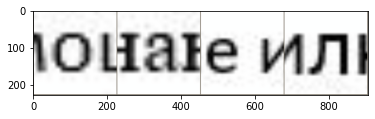

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.1588,  3.4624, -3.5309,  2.1434])
Predict class - times new roman, real class - arial, probability (arial,calibri) - tensor([ 1.3456,  1.6051,  1.9138, -4.6694])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.2111,  2.2009, -2.3690,  0.9511])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.7269,  4.0087,  0.7622, -4.1964])


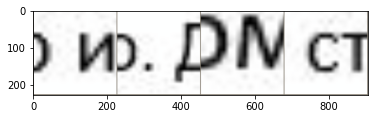

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.6461,  2.1663, -0.7748, -1.2541])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 3.8877, -0.2514,  0.4713, -2.9221])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 2.9691,  4.5705, -5.3898,  0.5851])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-1.0721, -0.4876, -3.1860,  6.6242])


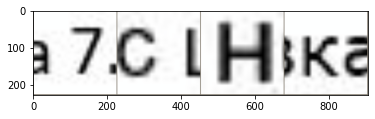

Predict class - arial, real class - verdana, probability (arial,calibri) - tensor([ 3.5077,  2.2780,  0.0573, -3.1479])
Predict class - arial, real class - verdana, probability (arial,calibri) - tensor([ 3.3256,  1.8319, -0.3262, -3.3022])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 3.5206,  6.4972, -3.6589, -5.4038])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-0.3844,  6.7105, -1.7962, -2.1940])


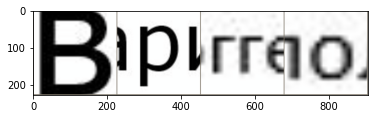

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 0.1971, -0.7651, -3.5533,  5.2975])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 5.6435,  0.4156,  0.2367, -5.3504])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.2376,  3.8485, -2.1707, -0.1945])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-1.3153,  0.5005, -1.1216,  4.1949])


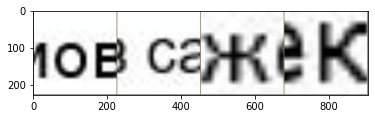

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-1.7772,  1.3673, -2.9851,  5.8034])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.6693,  6.8079, -1.2494, -4.1572])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 0.7122,  0.9728, -5.8875,  6.0384])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 2.8064, -0.9908, -6.1956,  6.5765])


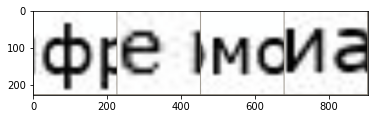

Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 3.9988,  2.2223, -1.7147, -3.9043])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-0.8047,  1.0409,  5.4439, -6.0874])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.9944, -0.0470, -2.3900,  4.6031])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 0.9560, -2.3386,  5.3020, -2.5332])


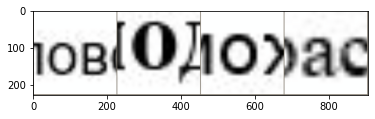

Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 5.1374,  0.9786,  0.7366, -5.3283])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 5.2193, -2.0008,  0.8290, -2.7137])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-0.6724, -0.1253,  5.3258, -3.3006])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 4.5250, -0.6521, -0.4621, -2.9637])


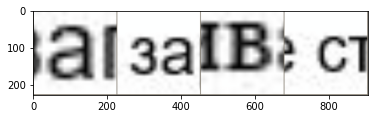

Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-2.6149, -1.1974,  7.0099, -3.6729])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 2.3538,  9.9748, -0.0906, -9.2134])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 3.5922,  5.9541, -2.9462, -3.8962])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-0.5908, -1.8480,  7.2274, -5.7591])


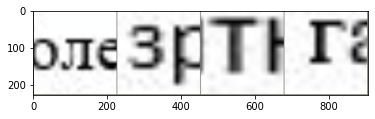

Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 0.9338,  1.6547,  4.6303, -5.7909])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 1.3931, -1.1164, -0.5233,  1.4142])
Predict class - arial, real class - verdana, probability (arial,calibri) - tensor([ 1.8429,  1.2778, -0.6804, -0.6203])
Predict class - arial, real class - verdana, probability (arial,calibri) - tensor([ 5.6663,  3.1585, -0.7126, -5.8433])


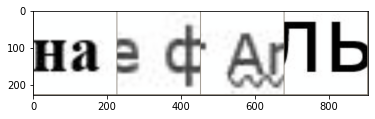

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.2377,  5.9430, -1.2498, -2.9449])
Predict class - arial, real class - verdana, probability (arial,calibri) - tensor([ 2.8010,  0.7072,  0.4847, -2.8150])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.9689,  7.7372, -0.5534, -6.6129])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.6568,  5.4253, -3.6832, -1.6379])


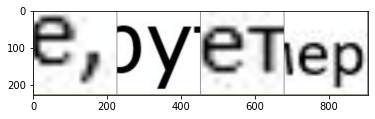

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.6955,  0.3738, -2.2350,  5.2275])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 1.5062, -2.2455, -3.0656,  6.4028])
Predict class - calibri, real class - verdana, probability (arial,calibri) - tensor([ 0.8784,  3.7113, -5.5453,  3.3519])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 1.7552,  0.8515,  3.3768, -4.4777])


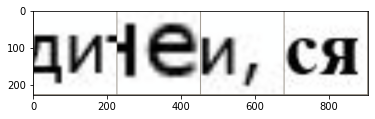

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 0.9843,  0.3316, -3.7348,  5.3025])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-4.0558, -2.9308,  6.4764, -0.2301])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-0.2383,  6.9400, -3.7878, -0.3632])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 3.4421,  1.4326, -1.4003, -1.5252])


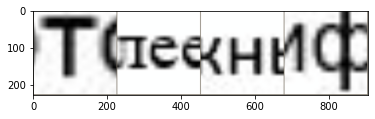

Predict class - arial, real class - calibri, probability (arial,calibri) - tensor([ 3.4398,  3.0409, -1.4064, -3.5276])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 0.8294, -2.4953,  9.6637, -6.7300])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-3.6958,  1.7647, -3.7691,  8.8968])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-1.8682, -3.4800,  7.5952, -3.0075])


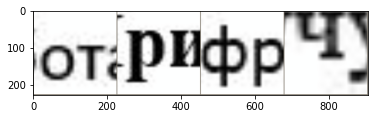

Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-3.2864, -1.3236,  6.6264, -1.5528])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 1.8286,  0.7342,  3.1381, -5.1056])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-0.1059,  7.8695,  1.2011, -7.4132])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-0.7748,  4.8923,  3.8727, -6.6692])


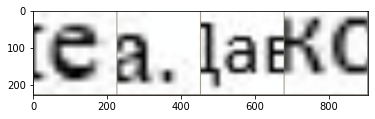

Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 5.8932,  5.0273, -0.4950, -8.2462])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-2.3653, -1.8481,  5.4978, -1.8633])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 1.7507,  1.6358, -1.0558, -0.6314])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 6.5082,  1.0239, -4.0400, -2.4893])


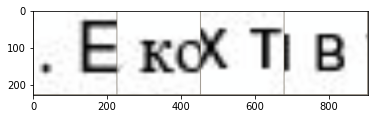

Predict class - calibri, real class - verdana, probability (arial,calibri) - tensor([ 2.0439,  3.2253, -3.3622,  0.9213])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 5.4220,  1.8885, -0.5868, -5.3145])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 2.8192,  3.5438, -0.6307, -4.3539])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.1412, 11.2892, -0.4936, -9.0755])


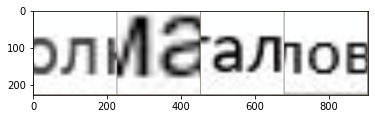

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.6748, -4.0216, -0.0473,  5.5093])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.3504,  5.0926,  3.2046, -6.4507])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 0.0201, -2.7660, -1.3909,  6.0229])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-0.8289,  5.9573, -0.5656, -2.8715])


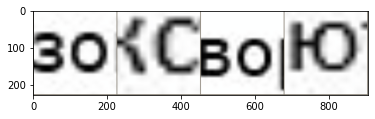

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 2.0254,  0.1403, -4.7898,  5.7613])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-2.9061, -2.9429,  6.2811, -0.1582])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 2.8683,  1.1726,  0.0894, -3.4066])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.1615,  7.1152, -1.5583, -3.8705])


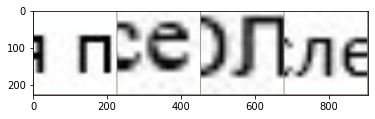

Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 5.1460,  2.3022, -4.9703, -1.3156])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 2.7330,  3.3835,  5.3966, -9.3877])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-2.7735, -3.6334,  8.6217, -3.9345])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 2.5899,  2.8092, -7.2952,  4.6564])


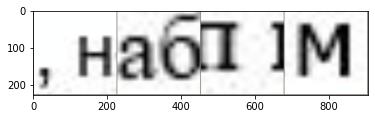

Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 5.5042,  4.5292, -5.2143, -2.9694])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-1.3266,  6.7649, -1.7866, -2.0270])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.2897, -3.5268, -0.0402,  4.9382])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-1.0223, -2.5640, -1.1488,  7.1530])


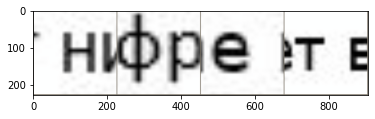

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-1.4121, -4.8021, -0.5339,  7.8211])
Predict class - arial, real class - verdana, probability (arial,calibri) - tensor([ 1.9231, -0.7102,  1.2960, -0.7357])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-3.9903, -0.4059, -0.5878,  6.1010])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 0.7302, -2.7892, -1.8778,  5.8180])


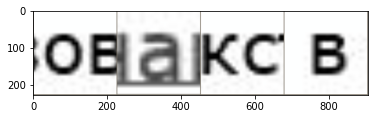

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 2.8270,  3.8401, -1.7935, -3.5281])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.1202, -1.0392, -1.8154,  3.5429])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 2.5247,  3.6792, -1.3478, -3.6881])
Predict class - times new roman, real class - calibri, probability (arial,calibri) - tensor([-2.0580, -1.0697,  4.7308, -1.3544])


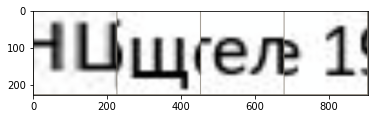

Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 4.3622, -0.2772,  2.3695, -5.7403])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.9789,  4.3019,  1.8781, -6.2026])
Predict class - arial, real class - calibri, probability (arial,calibri) - tensor([ 3.3334,  2.6475, -1.1116, -3.7370])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-2.2859, -3.2827, -1.1301,  8.0442])


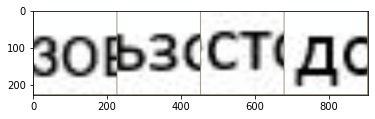

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.2602,  6.6395, -0.2921, -5.2054])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.2125,  6.7154, -2.2108, -3.2513])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 6.4208,  1.8422, -1.0105, -4.9911])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 2.3953,  5.7470, -1.2711, -4.2273])


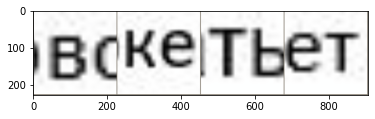

Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 2.2063,  0.3067,  4.7126, -5.6036])
Predict class - verdana, real class - arial, probability (arial,calibri) - tensor([ 1.5837,  2.4246, -4.6940,  2.8461])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 1.5359,  2.0354, -3.0225,  2.2445])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 1.7476,  1.5075,  1.1238, -3.7316])


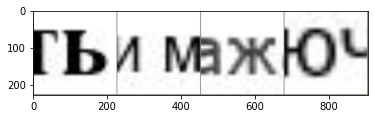

Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 2.8530,  2.6499,  0.1550, -4.6084])
Predict class - calibri, real class - verdana, probability (arial,calibri) - tensor([ 3.0084,  3.8474, -6.1268,  1.8914])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-2.2648, -4.5193,  8.8595, -2.5150])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 2.8268,  2.1837,  3.3015, -7.5967])


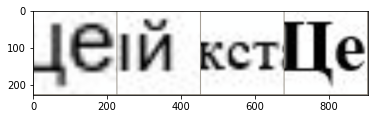

Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 4.1275,  0.5771,  0.0461, -4.6874])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 2.2932,  5.8776, -4.5306, -0.7150])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.8399,  3.2297, -3.4674,  0.4095])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-1.1854, -4.1314,  7.7383, -3.2631])


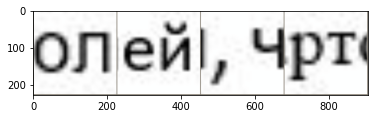

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 1.1485,  2.6426, -6.1418,  6.3139])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 0.7641, -1.2219, -3.4735,  5.9356])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.6521, -4.4388, -0.3834,  6.4643])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 1.1064,  0.4580, -3.0360,  2.4955])


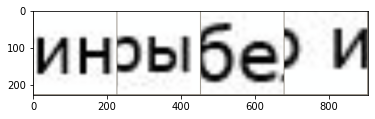

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-2.1983, -3.4532, -1.0597,  8.2735])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.2086,  7.1273,  0.4664, -5.2995])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.7231,  0.9617, -4.4301,  7.3872])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-2.4036, -0.1202, -2.6808,  6.8599])


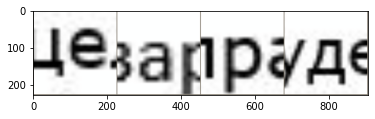

Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-1.8250, -5.0423, 11.0392, -3.2532])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 4.4203,  6.5005, -4.1071, -4.0414])


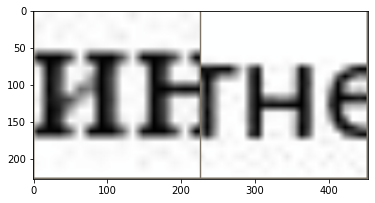

Accuracy of the network on the 134 test images: 89 %


In [162]:
# Visualization results of analysis test data
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        
        for printdata in list(zip(predicted,labels,outputs)):
            printclass =[classes[int(printdata[0])],classes[int(printdata[1])]]
            print('Predict class - {0}, real class - {1}, probability ({2},{3}) - {4}'.format( printclass[0],printclass[1],
                                                                              classes[0], classes [1],printdata[2]))

        total += labels.size(0)
        correct += int((predicted == labels).int().sum())
        imshow_resNet18(torchvision.utils.make_grid(images))
        #print('GroundTruth: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
print('Accuracy of the network on the', dataset_sizes['test'], 'test images: %d %%' % (
    100 * correct / total))

In [163]:
'''# Export model to onnx format
PATH =os.path.join(dir, "my_resnet18.onnx")
dummy_input = Variable(torch.randn(1, 3, 224, 224))
torch.onnx.export(model_ft, dummy_input, PATH)'''

'# Export model to onnx format\nPATH =os.path.join(dir, "my_resnet18.onnx")\ndummy_input = Variable(torch.randn(1, 3, 224, 224))\ntorch.onnx.export(model_ft, dummy_input, PATH)'

PTH

In [164]:
#Save and load model
PATH =os.path.join('/content/', "my_model.pth")
torch.save(net.state_dict(), PATH)
#load
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Pickle

In [165]:
 # Save a dictionary into a pickle file.
import pickle
pickle.dump(model_ft, open("model.pcl", "wb"))

In [166]:
model = pickle.load(open("model.pcl", "rb"))

Input for predict

In [168]:
#!rm -R .ipynb_checkpoints
#!ls -a  

In [169]:
#Create function to get your(my) images dataset and resize it to size for model
def get_dataset(data_dir, data_transforms):
    
    # create train and test datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['valid']}
    
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                 shuffle=True, num_workers=4)
                  for x in ['valid']}

    return dataloaders['valid']

In [170]:
data_dir = '/content/drive/MyDrive/datasets'
dataloaders_test = get_dataset(data_dir, data_transforms)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [171]:
correct = 0 
total = 0 

for data in dataloaders_test:
        
        images, labels = data
        print(labels)
        outputs = model(images)
        #print(outputs)
        _, predicted = torch.max(outputs.data, 1)
        #print(torch.max(outputs.data, 1))
        
        for printdata in list(zip(predicted,labels,outputs)):
            printclass =[classes[int(printdata[0])],classes[int(printdata[1])]]
            print('Predict class - {0}, real class - {1}, {2}'.format(printclass[0],printclass[1], printdata[2]))
            
        total += labels.size(0)
        correct += int((predicted == labels).int().sum())
        #imshow_resNet18(torchvision.utils.make_grid(images))
        #print('GroundTruth: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

print('Accuracy of the network: {}'.format(correct / total))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([3, 1, 0, 1])
Predict class - verdana, real class - verdana, tensor([ 1.1587,  1.9929, -3.4507,  2.0967], grad_fn=<UnbindBackward0>)
Predict class - calibri, real class - calibri, tensor([ 0.5601,  6.3270,  0.2499, -5.6232], grad_fn=<UnbindBackward0>)
Predict class - arial, real class - arial, tensor([ 3.1386,  2.0710,  1.1347, -5.3589], grad_fn=<UnbindBackward0>)
Predict class - calibri, real class - calibri, tensor([ 0.9234,  5.6628, -2.3855, -2.7706], grad_fn=<UnbindBackward0>)
tensor([3, 3, 2, 3])
Predict class - verdana, real class - verdana, tensor([-0.4884,  0.9306, -2.8298,  4.9718], grad_fn=<UnbindBackward0>)
Predict class - verdana, real class - verdana, tensor([-1.0453, -0.1843, -2.2813,  5.6069], grad_fn=<UnbindBackward0>)
Predict class - times new roman, real class - times new roman, tensor([-0.1684,  1.9256,  2.6653, -3.0953], grad_fn=<UnbindBackward0>)
Predict class - verdana, real class - verdana, tensor([-2.5712, -1.0273, -2.5468,  9.1408], grad_fn=<UnbindBackwa

Preprocess img

In [172]:
# model expects 224x224 3-color image
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

In [173]:
#preprocess input image
def preprocess_input(image_pth):

  try:
    test_img = Image.open(image_pth).convert('RGB')
    transformed_img = transform(test_img)
    input_img = transform_normalize(transformed_img)
  except:
    test_img = image_pth.convert('RGB')
    transformed_img = transform(test_img)
    input_img = transform_normalize(transformed_img)

  return input_img.unsqueeze(0) # the model requires a dummy batch dimension

In [174]:
#0-arial, 1-calibri, 2-tnr, 3-verdana
def pred_font(output):
  if (output == output.max().item()).nonzero()[0][1] == torch.tensor(0):
    return 'arial'
  elif (output == output.max().item()).nonzero()[0][1] == torch.tensor(1):
    return 'calibri'
  elif (output == output.max().item()).nonzero()[0][1] == torch.tensor(2):
    return 'times new roman'
  else:
    return 'verdana'

Valid dataset

In [175]:
%%timeit
image_pth = '/content/drive/MyDrive/datasets/valid/verdana/5.jpg'
input_img = preprocess_input(image_pth)
pred_font(model(input_img))          

10 loops, best of 5: 101 ms per loop


In [176]:
image_pth = '/content/drive/MyDrive/datasets/valid/verdana/5.jpg'
input_img = preprocess_input(image_pth)
pred_font(model(input_img))

'verdana'

In [177]:
image_pth = '/content/drive/MyDrive/datasets/valid/arial/2.jpg'
input_img = preprocess_input(image_pth)
pred_font(model(input_img)) 

'arial'

In [178]:
image_pth = '/content/drive/MyDrive/datasets/valid/times new roman/5.jpg'
input_img = preprocess_input(image_pth)
pred_font(model(input_img))       

'times new roman'

In [179]:
image_pth = '/content/drive/MyDrive/datasets/valid/times new roman/2.jpg'
input_img = preprocess_input(image_pth)
pred_font(model(input_img))      

'times new roman'

In [180]:
image_pth = '/content/test10.png'
input_img = preprocess_input(image_pth)
pred_font(model(input_img)) 

'calibri'

Создание датасета ч\з EasyOCR из изображения

In [181]:
'''!pip install opencv-python-headless==4.1.2.30
!pip install easyocr
!pip install pymorphy2'''

'!pip install opencv-python-headless==4.1.2.30\n!pip install easyocr\n!pip install pymorphy2'

In [182]:
'''import numpy as np
import pandas as pd
from PIL import Image, ImageFont, ImageDraw
import easyocr
from google.colab.patches import cv2_imshow
import re
import pymorphy2
from tqdm import tqdm

morph = pymorphy2.MorphAnalyzer()'''

'import numpy as np\nimport pandas as pd\nfrom PIL import Image, ImageFont, ImageDraw\nimport easyocr\nfrom google.colab.patches import cv2_imshow\nimport re\nimport pymorphy2\nfrom tqdm import tqdm\n\nmorph = pymorphy2.MorphAnalyzer()'

In [183]:
'''def easy_OCR(image, lang):
  
  #image's data
  reader = easyocr.Reader([lang]) 
  result = reader.readtext(image)#, width_ths=0.7, mag_ratio=3, canvas_size=4000)

  return result'''

"def easy_OCR(image, lang):\n  \n  #image's data\n  reader = easyocr.Reader([lang]) \n  result = reader.readtext(image)#, width_ths=0.7, mag_ratio=3, canvas_size=4000)\n\n  return result"

In [184]:
'''#func for get dataset
!mkdir dataset

def get_train_data(data, image, font='None', last=0):

    labels = pd.DataFrame()
    expansion = 5

    for idx in tqdm(range(len(data))):

            top = data[idx][0][0][1]
            left = data[idx][0][0][0]
            right = data[idx][0][2][0]
            bottom = data[idx][0][2][1]
            
            img = image.crop((left, top, right, bottom))
            img = img.convert("L")
            img.save('/content/dataset/'+str(idx+last)+'.jpg')
            
            labels = labels.append({'filename': str(idx+last)+".jpg",
                                    'file': np.matrix(img),
                                    'img': img,
                                    'font': font, 
                                    'word': data[idx][1]},
                                   ignore_index=True)

    return labels'''

'#func for get dataset\n!mkdir dataset\n\ndef get_train_data(data, image, font=\'None\', last=0):\n\n    labels = pd.DataFrame()\n    expansion = 5\n\n    for idx in tqdm(range(len(data))):\n\n            top = data[idx][0][0][1]\n            left = data[idx][0][0][0]\n            right = data[idx][0][2][0]\n            bottom = data[idx][0][2][1]\n            \n            img = image.crop((left, top, right, bottom))\n            img = img.convert("L")\n            img.save(\'/content/dataset/\'+str(idx+last)+\'.jpg\')\n            \n            labels = labels.append({\'filename\': str(idx+last)+".jpg",\n                                    \'file\': np.matrix(img),\n                                    \'img\': img,\n                                    \'font\': font, \n                                    \'word\': data[idx][1]},\n                                   ignore_index=True)\n\n    return labels'

In [185]:
'''#check image for font
from collections import Counter

def fonts_image(labels):

  font = []

  for image in tqdm(labels):

      input_img = preprocess_input(image)
      font.append(pred_font(model(input_img)))

  return Counter(font)'''

'#check image for font\nfrom collections import Counter\n\ndef fonts_image(labels):\n\n  font = []\n\n  for image in tqdm(labels):\n\n      input_img = preprocess_input(image)\n      font.append(pred_font(model(input_img)))\n\n  return Counter(font)'

In [186]:
'''#realize get dataset
image = '/content/text3.png'
result = easy_OCR(image, lang="ru")
labels = get_train_data(result, Image.open(image))
fonts_image(labels['img'])'''

'#realize get dataset\nimage = \'/content/text3.png\'\nresult = easy_OCR(image, lang="ru")\nlabels = get_train_data(result, Image.open(image))\nfonts_image(labels[\'img\'])'

In [187]:
'''#вырезаем однотонные линии по горизонтали
def crop_img(image_pth):

  COUNT_IMG = 30 #подобрать параметр ??
  cropped_image_array = []
  image = Image.open(image_pth)

  len_image_horizontal = np.array(image).shape[0]/COUNT_IMG
  len_image_vertical = np.array(Image.open(image_pth)).shape[1]/COUNT_IMG
  
  for elem_horizontal in range(COUNT_IMG):
    for elem_vertical in range(COUNT_IMG):
      left = (elem_horizontal-1) * len_image_horizontal
      top = (elem_vertical-1) * len_image_vertical
      right = elem_horizontal * len_image_horizontal
      bottom = elem_vertical * len_image_vertical

      cropped_image = image.crop((left, top, right, bottom))
      cropped_image_array.append(cropped_image)

  return cropped_image_array'''

'#вырезаем однотонные линии по горизонтали\ndef crop_img(image_pth):\n\n  COUNT_IMG = 30 #подобрать параметр ??\n  cropped_image_array = []\n  image = Image.open(image_pth)\n\n  len_image_horizontal = np.array(image).shape[0]/COUNT_IMG\n  len_image_vertical = np.array(Image.open(image_pth)).shape[1]/COUNT_IMG\n  \n  for elem_horizontal in range(COUNT_IMG):\n    for elem_vertical in range(COUNT_IMG):\n      left = (elem_horizontal-1) * len_image_horizontal\n      top = (elem_vertical-1) * len_image_vertical\n      right = elem_horizontal * len_image_horizontal\n      bottom = elem_vertical * len_image_vertical\n\n      cropped_image = image.crop((left, top, right, bottom))\n      cropped_image_array.append(cropped_image)\n\n  return cropped_image_array'

In [188]:
'''image = Image.open('/content/text3.png')

#удаление однотонных строк по горизонтали
def clean_img(image):

  elem2crop = []
  new_tensor = []

  elem2crop.extend([elem for elem in tqdm(range(len(np.array(image)))) if np.array(image)[elem].min() == np.array(image)[elem].max()])
  
  new_tensor.extend([np.array(image)[elem] for elem in tqdm(range(len(np.array(image)))) if elem not in elem2crop])

  return Image.fromarray(np.array(new_tensor))'''

"image = Image.open('/content/text3.png')\n\n#удаление однотонных строк по горизонтали\ndef clean_img(image):\n\n  elem2crop = []\n  new_tensor = []\n\n  elem2crop.extend([elem for elem in tqdm(range(len(np.array(image)))) if np.array(image)[elem].min() == np.array(image)[elem].max()])\n  \n  new_tensor.extend([np.array(image)[elem] for elem in tqdm(range(len(np.array(image)))) if elem not in elem2crop])\n\n  return Image.fromarray(np.array(new_tensor))"

Get chunk of image for prediction

In [189]:
#get word in the Image
def word_detection(image: Image):

  coordinate = list()
  chunk = list()
  amendment = 2

  cv_image = np.array(image)
  
  kernel_len = int(np.array(cv_image).shape[1]/100)
  hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 8))
  cv_text_detected_image = cv2.morphologyEx(cv_image, cv2.MORPH_OPEN, hor_kernel)
  #detects the contours
  contours, c = cv2.findContours(cv_text_detected_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
  
  #ellipsis = [cv2.fitEllipse(i)\
   #           for i in contours if i.shape[0] > 10 and (cv2.contourArea(i) < (cv_image.shape[0] * cv_image.shape[1]*0.1))]
  
  #the code below is get coordinate of text
  if len(contours) !=0:
    for contour in contours:
        if cv2.contourArea((contour)) > 500:
            x,y,w,h = cv2.boundingRect(contour)
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,),1)
            coordinate.append([x-amendment, y-amendment, x+w+amendment, y+h+amendment])

  #the code below is dividing the image into chunk of text
  chunk.extend([image.crop(tuple(coordinate_elem)) for coordinate_elem in coordinate])

  return chunk

In [192]:
#get chunk of text to predict
def get_predict_chunk(image):

  font = list()

  chunk = word_detection(image)

  for image in tqdm(chunk):

        input_img = preprocess_input(image)
        font.append(pred_font(model(input_img)))

  return Counter(font)

In [194]:
image = Image.open('/content/text3.png').convert('L')

get_predict_chunk(image)

100%|██████████| 92/92 [00:09<00:00, 10.02it/s]


Counter({'arial': 73, 'calibri': 15, 'times new roman': 3, 'verdana': 1})

In [195]:
image = Image.open('/content/text_calibri.png').convert('L')

get_predict_chunk(image)

100%|██████████| 71/71 [00:07<00:00,  9.31it/s]


Counter({'calibri': 70, 'times new roman': 1})

In [196]:
image = Image.open('/content/text_tnr.png').convert('L')

get_predict_chunk(image)

100%|██████████| 57/57 [00:06<00:00,  9.28it/s]


Counter({'times new roman': 57})

In [197]:
%%timeit
get_predict_chunk(image)

100%|██████████| 57/57 [00:05<00:00,  9.99it/s]

1 loop, best of 5: 5.67 s per loop
